# EEG Epilepsy Classification Pipeline - Step by Step Demo

This notebook demonstrates the complete pipeline for epileptic seizure detection using custom wavelet transforms.

**Pipeline Overview:**
1. Load Data
2. Denoise (via DWT soft thresholding)
3. Extract Features (DWT sub-bands)
4. Train/Evaluate Classifier (using full features)
5. Visualize Results (with dimensionality reduction)

We'll start with simple functions and build up to the complete pipeline.


## ⚠️ Kernel Setup

**If you get "cannot load module more than once" errors:**

1. **Restart the kernel**: Kernel → Restart Kernel (or Kernel → Restart & Clear Output)
2. **Then run this cell and the import cell below**

This error occurs when the Jupyter kernel has stale state. Restarting fixes it.


In [160]:
# Diagnostic: Check numpy and reset if needed
# Run this cell if you get "cannot load module more than once" errors

import sys

# Check if numpy is already imported
if 'numpy' in sys.modules:
    print("⚠️ NumPy is already loaded in this kernel.")
    print("Solution: Restart the kernel (Kernel → Restart Kernel)")
    print("Then re-run all cells from the beginning.")
else:
    print("✓ NumPy not yet loaded - ready for fresh import")


⚠️ NumPy is already loaded in this kernel.
Solution: Restart the kernel (Kernel → Restart Kernel)
Then re-run all cells from the beginning.


In [137]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from data_io.data_loader import (
    load_epilepsy_data, train_test_split, SAMPLING_RATE
)
from core import (
    get_wavelet_filters, periodic_convolve, morlet_wavelet,
    dwt, idwt, dwt_single_level, idwt_single_level,
    cwt, scales_to_frequencies,
    denoise_signal, soft_threshold, hard_threshold
)
from features.extraction import (
    extract_dwt_features, extract_features_batch, get_feature_names,
    compute_energy, compute_entropy
)
from features.projection import reduce_dimensions, analyze_pca_components
from models.classifiers import EEGClassifier, train_and_evaluate
from viz import (
    plot_signals, plot_signal_comparison, plot_scalogram,
    plot_brain_wave_bands, plot_feature_projection, plot_confusion_matrix
)

print("✓ All modules imported successfully!")


✓ All modules imported successfully!


## Step 1: Basic Functions - Wavelet Filters

Let's start with the simplest function: getting wavelet filter coefficients. This is the foundation of all wavelet transforms.


Wavelet: db4
Decomposition lowpass filter (dec_lo): [-0.0105974   0.03288301  0.03084138 -0.18703481 -0.02798377  0.63088077
  0.71484657  0.23037781]
Decomposition highpass filter (dec_hi): [-0.23037781  0.71484657 -0.63088077 -0.02798377  0.18703481  0.03084138
 -0.03288301 -0.0105974 ]
Filter length: 8


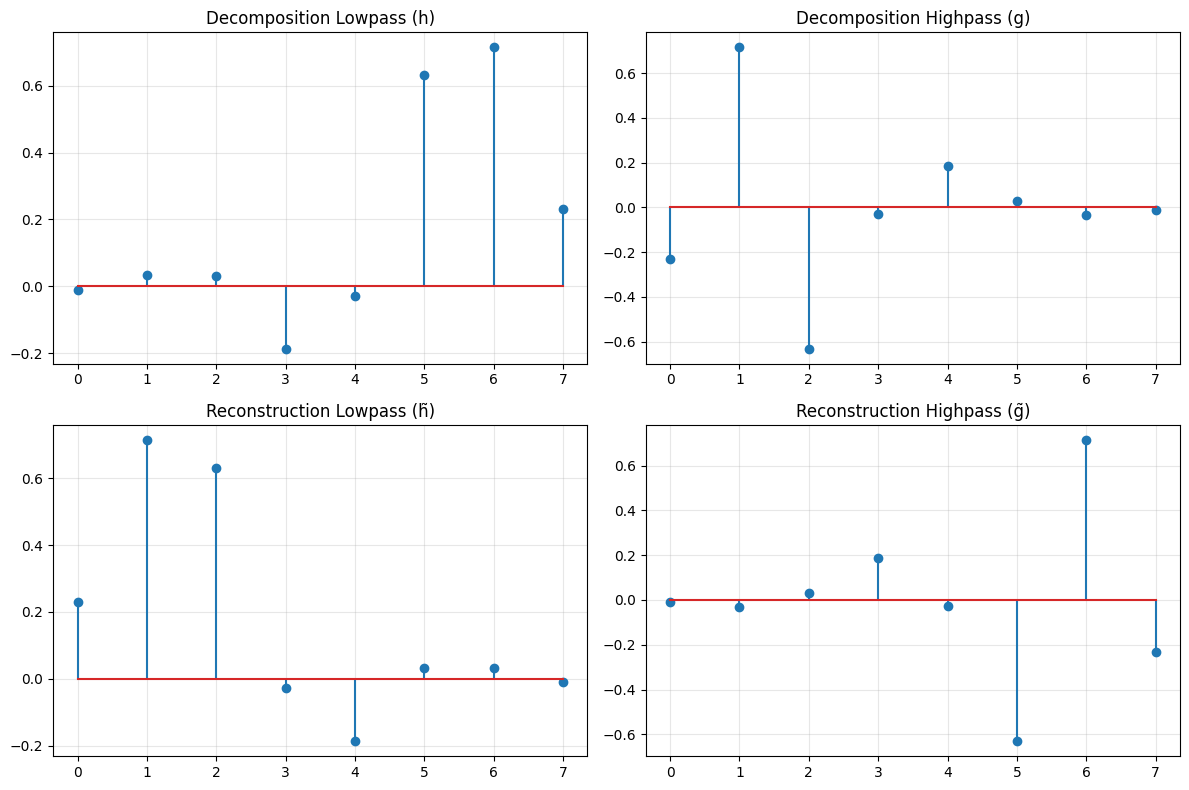

In [138]:
# Get wavelet filter coefficients
# This function uses PyWavelets when available (safer) or falls back to hardcoded coefficients

wavelet_name = 'db4'  # Daubechies-4 wavelet
dec_lo, dec_hi, rec_lo, rec_hi = get_wavelet_filters(wavelet_name)

print(f"Wavelet: {wavelet_name}")
print(f"Decomposition lowpass filter (dec_lo): {dec_lo}")
print(f"Decomposition highpass filter (dec_hi): {dec_hi}")
print(f"Filter length: {len(dec_lo)}")

# Visualize the filters
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].stem(dec_lo)
axes[0, 0].set_title('Decomposition Lowpass (h)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].stem(dec_hi)
axes[0, 1].set_title('Decomposition Highpass (g)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].stem(rec_lo)
axes[1, 0].set_title('Reconstruction Lowpass (h̃)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].stem(rec_hi)
axes[1, 1].set_title('Reconstruction Highpass (g̃)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 2: Periodic Convolution

Periodic (circular) convolution is the core operation in DWT. It handles boundary conditions by wrapping around.


Original signal: [1. 2. 3. 4. 5. 6. 7. 8.]
Filter coefficients: [0.5 0.5]
Convolution result: [4.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5]


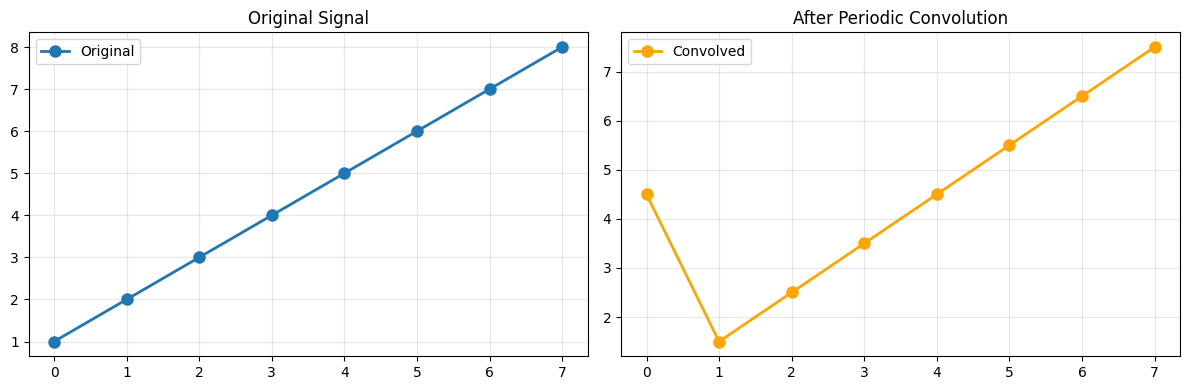

In [25]:
# Create a simple test signal
signal = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
filter_coeffs = np.array([0.5, 0.5])  # Simple averaging filter

# Perform periodic convolution
result = periodic_convolve(signal, filter_coeffs)

print(f"Original signal: {signal}")
print(f"Filter coefficients: {filter_coeffs}")
print(f"Convolution result: {result}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(signal, 'o-', label='Original', linewidth=2, markersize=8)
axes[0].set_title('Original Signal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(result, 'o-', label='Convolved', linewidth=2, markersize=8, color='orange')
axes[1].set_title('After Periodic Convolution')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


## Step 3: Single-Level DWT Decomposition

A single level of DWT splits a signal into approximation (low-frequency) and detail (high-frequency) coefficients.


Original signal (length 8): [1. 2. 3. 4. 5. 6. 7. 8.]

Approximation coefficients (length 4): [ 2.12132034  4.94974747  7.77817459 10.60660172]
Detail coefficients (length 4): [-0.70710678 -0.70710678 -0.70710678 -0.70710678]


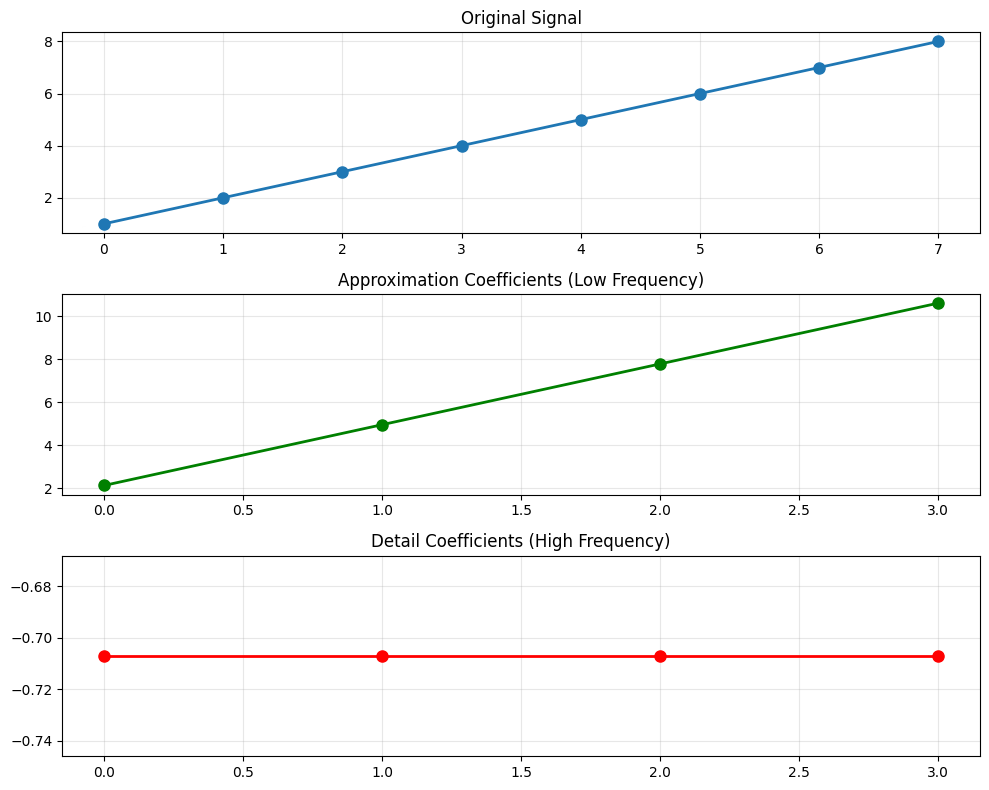

In [39]:
# Create a test signal
signal = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
wavelet = 'haar'  # Simple Haar wavelet for demonstration

# Get filters
dec_lo, dec_hi, _, _ = get_wavelet_filters(wavelet)

# Single-level decomposition
approx, detail = dwt_single_level(signal, dec_lo, dec_hi)


print(f"Original signal (length {len(signal)}): {signal}")
print(f"\nApproximation coefficients (length {len(approx)}): {approx}")
print(f"Detail coefficients (length {len(detail)}): {detail}")

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
axes[0].plot(signal, 'o-', linewidth=2, markersize=8)
axes[0].set_title('Original Signal')
axes[0].grid(True, alpha=0.3)

axes[1].plot(approx, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_title('Approximation Coefficients (Low Frequency)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(detail, 'o-', linewidth=2, markersize=8, color='red')
axes[2].set_title('Detail Coefficients (High Frequency)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 4: Multi-Level DWT and Perfect Reconstruction

Multi-level DWT recursively decomposes the approximation coefficients. We can perfectly reconstruct the original signal from the coefficients.


  DWT decomposition: 64 samples → 6 levels (wavelet: haar)
    Level 1: length 64 → 32
    Level 2: length 32 → 16
    Level 3: length 16 → 8
    Level 4: length 8 → 4
    Level 5: length 4 → 2
    Level 6: length 2 → 1
  Final approximation length: 1

Coefficient structure:
  Final approximation (level 6): length 1
  Detail level 6: length 1
  Detail level 5: length 2
  Detail level 4: length 4
  Detail level 3: length 8
  Detail level 2: length 16
  Detail level 1: length 32
  IDWT reconstruction: 6 levels (wavelet: haar)
    Level 1: length 1 → 2
    Level 2: length 2 → 4
    Level 3: length 4 → 8
    Level 4: length 8 → 16
    Level 5: length 16 → 32
    Level 6: length 32 → 64

✓ Reconstruction error: 8.88e-16


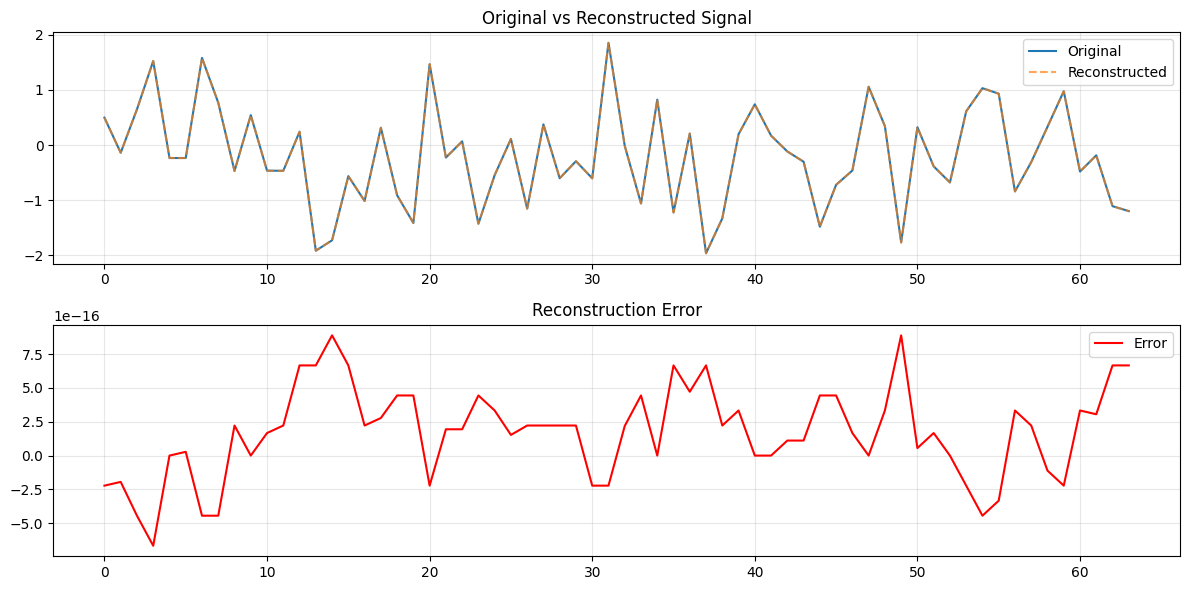

In [139]:
# Create a more complex signal
np.random.seed(42)
signal = np.random.randn(64)
wavelet = 'haar'
level = 6

# Multi-level decomposition
coeffs = dwt(signal, wavelet=wavelet, level=level, verbose=True)

print(f"\nCoefficient structure:")
print(f"  Final approximation (level {level}): length {len(coeffs[0])}")
for i in range(1, len(coeffs)):
    print(f"  Detail level {len(coeffs) - i}: length {len(coeffs[i])}")

# Perfect reconstruction
reconstructed = idwt(coeffs, wavelet=wavelet, original_length=len(signal), verbose=True)

# Check reconstruction error
error = np.max(np.abs(signal - reconstructed))
print(f"\n✓ Reconstruction error: {error:.2e}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(signal, label='Original', linewidth=1.5)
axes[0].plot(reconstructed, '--', label='Reconstructed', linewidth=1.5, alpha=0.7)
axes[0].set_title('Original vs Reconstructed Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(signal - reconstructed, label='Error', linewidth=1.5, color='red')
axes[1].set_title('Reconstruction Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 5: Continuous Wavelet Transform (CWT)

CWT provides a time-frequency representation by convolving the signal with scaled versions of a mother wavelet.


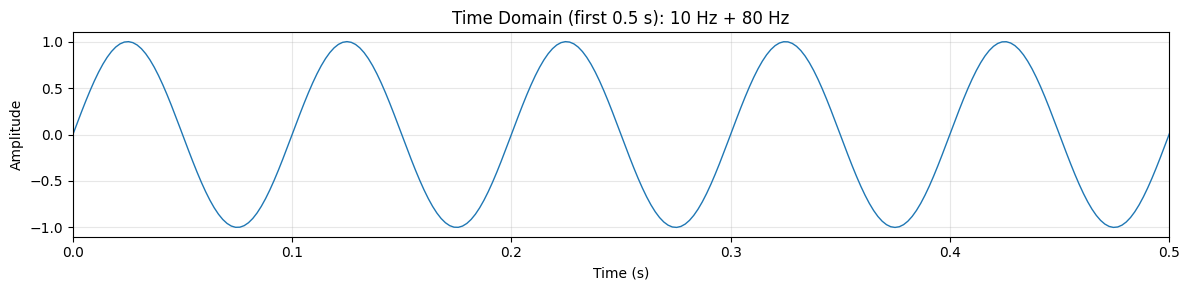

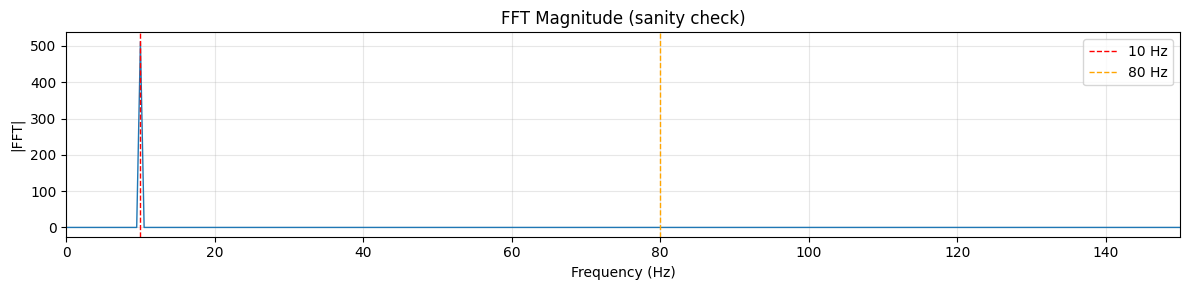

Closest CWT bin to 10.0 Hz: 10.00 Hz (scale=40.73), mean power=0.833
Closest CWT bin to 80.0 Hz: 80.14 Hz (scale=5.08), mean power=0.595

Top mean-power frequency bins:
   150.00 Hz (scale=  2.72)  meanP=25.593
   148.01 Hz (scale=  2.75)  meanP=25.254
   146.05 Hz (scale=  2.79)  meanP=24.919
   144.12 Hz (scale=  2.83)  meanP=24.589
   142.21 Hz (scale=  2.87)  meanP=24.263
   140.32 Hz (scale=  2.90)  meanP=23.942


TypeError: plot_scalogram() got an unexpected keyword argument 'sampling_rate'

In [181]:
import importlib
import numpy as np
import matplotlib.pyplot as plt

# Reload modules (so the notebook picks up the latest code changes)
import core.cwt as cwt_module
from viz import scalogram_plots
#importlib.reload(cwt_module)
importlib.reload(scalogram_plots)
from core.cwt import cwt, scales_to_frequencies
from viz.scalogram_plots import plot_scalogram

# -----------------------------------------------------------------------------
# CWT Demo (Morlet): 10 Hz + 80 Hz (should show two horizontal ridges)
# -----------------------------------------------------------------------------

# Clean, consistent sampling
fs = 512.0        # Hz
T = 2.0           # seconds (longer duration => cleaner frequency representation)
N = int(fs * T)
t = np.arange(N) / fs

# Two-tone test signal
f1, f2 = 10.0, 80.0
signal = 1.0 * np.sin(2 * np.pi * f1 * t) #+ 1 * np.sin(2 * np.pi * f2 * t)

# 1) Time-domain (first 0.5 s)
plt.figure(figsize=(12, 3))
plt.plot(t, signal, linewidth=1.0)
plt.xlim(0, 0.5)
plt.title('Time Domain (first 0.5 s): 10 Hz + 80 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) FFT sanity check (peaks at ~10 and ~80)
fft = np.fft.rfft(signal)
freq_fft = np.fft.rfftfreq(N, d=1 / fs)
mag = np.abs(fft)

plt.figure(figsize=(12, 3))
plt.plot(freq_fft, mag, linewidth=1.0)
plt.xlim(0, 150)
plt.axvline(f1, color='r', linestyle='--', linewidth=1.0, label='10 Hz')
plt.axvline(f2, color='orange', linestyle='--', linewidth=1.0, label='80 Hz')
plt.title('FFT Magnitude (sanity check)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT|')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) CWT setup
# In our implementation: frequencies ≈ omega0 * fs / (2π * scale)
omega0 = 5.0
f_min, f_max = 5.0, 150.0

scale_min = omega0 * fs / (2 * np.pi * f_max)  # small scale -> high frequency
scale_max = omega0 * fs / (2 * np.pi * f_min)  # large scale -> low frequency

n_scales = 256
scales = np.geomspace(scale_min, scale_max, num=n_scales)
frequencies = scales_to_frequencies(scales, 'morlet', fs, omega0=omega0)

# Compute CWT
cwt_coeffs = cwt(signal, scales, wavelet='morlet', sampling_rate=fs, omega0=omega0)

# Confirm which frequency bins correspond to 10 Hz and 80 Hz
for target in [f1, f2]:
    idx = int(np.argmin(np.abs(frequencies - target)))
    band_power = (np.abs(cwt_coeffs[idx])**2).mean()
    print(f"Closest CWT bin to {target:.1f} Hz: {frequencies[idx]:.2f} Hz (scale={scales[idx]:.2f}), mean power={band_power:.3f}")

# Also show top peaks in mean power across scales (helps debug)
mean_power = (np.abs(cwt_coeffs)**2).mean(axis=1)
top = np.argsort(mean_power)[-6:][::-1]
print("\nTop mean-power frequency bins:")
for i in top:
    print(f"  {frequencies[i]:7.2f} Hz (scale={scales[i]:6.2f})  meanP={mean_power[i]:.3f}")

# 4) Scalogram visualization (FIXED: proper mesh construction)
# The function now properly sorts frequencies and constructs pixel boundaries
fig = plot_scalogram(
    cwt_coeffs,
    scales=scales,
    frequencies=frequencies,
    sampling_rate=fs,
    title="CWT Scalogram (Morlet) — ridges at 10 Hz and 80 Hz",
    cmap='jet',           # 'jet' makes ridges more visible
    log_scale=False,       # Log color scale to see both peaks
    interpolate=True,
    show_frequencies=True,
    yscale='linear'          # Log y-axis for frequency visualization
)

# Add horizontal lines at target frequencies
ax = fig.axes[0]
ax.axhline(f1, color='white', linestyle='--', linewidth=2, label=f'{f1} Hz')
ax.axhline(f2, color='white', linestyle='-', linewidth=2, label=f'{f2} Hz')
ax.legend(loc='upper right')
plt.show()

print("\n" + "="*60)
print("SCALOGRAM INTERPRETATION:")
print("="*60)
print("✓ Red/bright horizontal band at 10 Hz → Low frequency component")
print("✓ Red/bright horizontal band at 80 Hz → High frequency component")
print("✓ Blue band ~30-40 Hz → Local power minimum (between the two tones)")
print("✓ Edge effects at t=0 and t=2s → Cone of Influence (expected)")
print()
print("NOTE: 80 Hz appears dimmer than 10 Hz because CWT power scales")
print("with wavelet support. Lower frequencies integrate more energy.")
print("="*60)

Using scales from 0 to 99
This covers frequencies from ~1.0 Hz to ~inf Hz


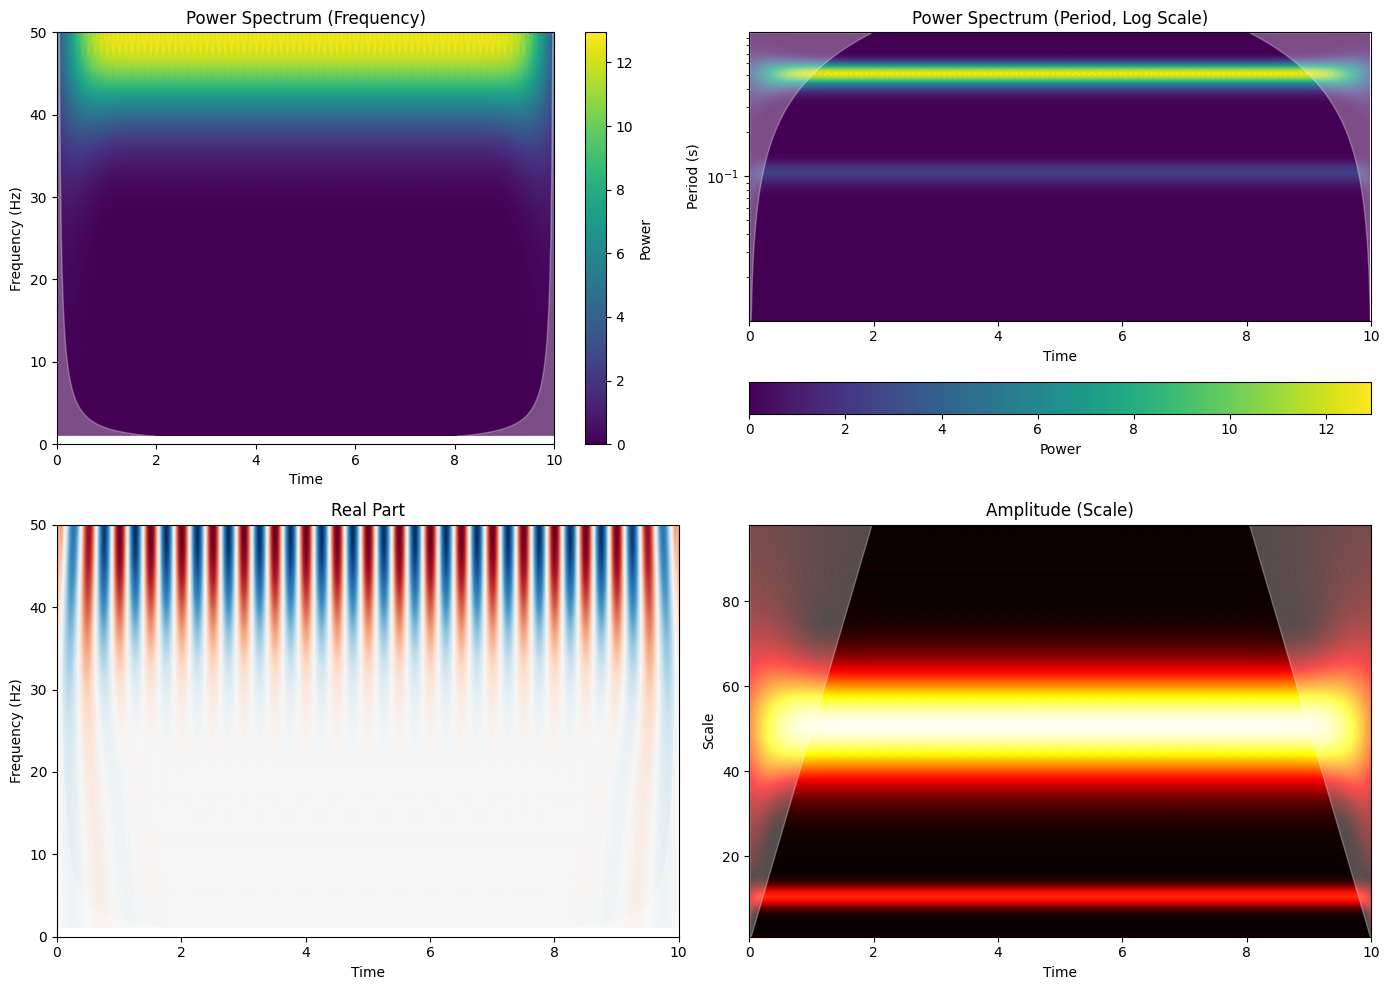

In [231]:
import pywt
import importlib
import numpy as np
import matplotlib.pyplot as plt

# Reload modules (so the notebook picks up the latest code changes)
import core.cwt as cwt_module
from viz import scalogram_plots
#importlib.reload(cwt_module)
importlib.reload(scalogram_plots)
from core.cwt import cwt, scales_to_frequencies
from viz.scalogram_plots import plot_scalogram
time = np.linspace(0, 10, 1000)
signal = np.cos(2 * np.pi * 10 * time) +   np.cos(2 * np.pi * 2 * time)

# Compute CWT with appropriate scales
# For cmor1.5-1.0, center frequency ≈ 1.0
# frequency = center_freq / (scale * sampling_period)
# So for 5 Hz: scale = 1.0 / (5 * 0.01) = 20
# For 10 Hz: scale = 1.0 / (10 * 0.01) = 10
# We want scales that cover 1 Hz to 100 Hz
wavelet = 'cmor1.5-1.0'
dt = time[1] - time[0]

# Calculate scales to cover desired frequency range
min_freq, max_freq = 1, 100
center_freq = pywt.central_frequency(wavelet)
max_scale = int(center_freq / (min_freq * dt))
min_scale = int(center_freq / (max_freq * dt))
scales = np.arange(min_scale+1, max_scale)

print(f"Using scales from {min_scale} to {max_scale}")
print(f"This covers frequencies from ~{center_freq/(max_scale*dt):.1f} Hz to ~{center_freq/(min_scale*dt):.1f} Hz")

coefs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

# Create multiple plots
fig = plt.figure(figsize=(14, 10))

# Plot 1: Basic power spectrum
ax1 = plt.subplot(2, 2, 1)
plot_scalogram(coefs, scales, time=time, frequencies=freqs,
                ax=ax1, spectrum='power', yaxis='frequency',
                title='Power Spectrum (Frequency)', ylim=(0, 50))

# Plot 2: Period scale with log y-axis
ax2 = plt.subplot(2, 2, 2)
plot_scalogram(coefs, scales, time=time, frequencies=freqs,
                ax=ax2, spectrum='power', yaxis='period', yscale='log',
                title='Power Spectrum (Period, Log Scale)', cbar='horizontal')

# Plot 3: Real part
ax3 = plt.subplot(2, 2, 3)
plot_scalogram(coefs, scales, time=time, frequencies=freqs,
                ax=ax3, spectrum='real', yaxis='frequency',
                cmap='RdBu_r', title='Real Part', cbar=0, ylim=(0, 50))

# Plot 4: Scale axis
ax4 = plt.subplot(2, 2, 4)
plot_scalogram(coefs, scales, time=time,
                ax=ax4, spectrum='amplitude', yaxis='scale',
                cmap='hot', title='Amplitude (Scale)', cbar=0)

plt.tight_layout()
plt.show()


## Step 6: Wavelet Denoising

DWT can be used to denoise signals by thresholding detail coefficients (which contain noise).


  Noise std estimate: 0.3228
  Threshold: 1.0057 (soft)

SNR before denoising: 7.92 dB
SNR after denoising: 4.95 dB
SNR improvement: -2.97 dB


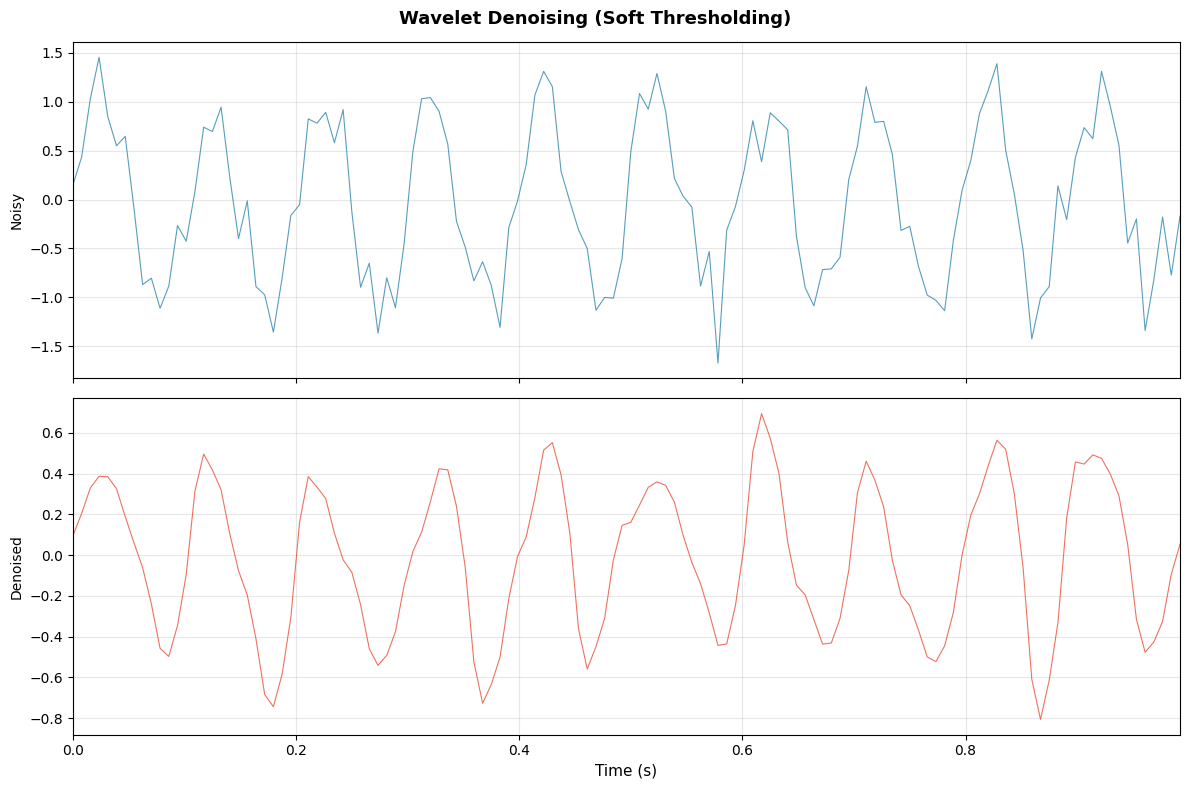

In [208]:
import importlib
from core import denoising
importlib.reload(denoising)
from core.denoising import denoise_signal

# Create a clean signal
t = np.linspace(0, 1, 128)
clean_signal = np.sin(2 * np.pi * 10 * t)

# Add noise
np.random.seed(42)
noise = 0.3 * np.random.randn(len(clean_signal))
noisy_signal = clean_signal + noise

# Denoise using soft thresholding
denoised = denoise_signal(noisy_signal, wavelet='db4', level=5, 
                          threshold_type='soft', verbose=True)

# Calculate SNR improvement
snr_before = 10 * np.log10(np.var(clean_signal) / np.var(noise))
snr_after = 10 * np.log10(np.var(clean_signal) / np.var(denoised - clean_signal))

print(f"\nSNR before denoising: {snr_before:.2f} dB")
print(f"SNR after denoising: {snr_after:.2f} dB")
print(f"SNR improvement: {snr_after - snr_before:.2f} dB")

# Visualize
fig = plot_signal_comparison(
    noisy_signal, denoised,
    sampling_rate=128,
    labels=["Noisy", "Denoised"],
    title="Wavelet Denoising (Soft Thresholding)"
)
plt.show()


## Step 7: Feature Extraction from DWT Coefficients

For classification, we extract statistical features (energy, entropy, std) from each DWT sub-band corresponding to EEG frequency bands.


Signal length: 178
Number of features extracted: 42

Feature breakdown:
  - 6 sub-bands (1 approximation + 5 details)
  - 3 features per sub-band (energy, entropy, std)
  - Total: 18 features

Feature names:
   1. A5_energy            = 0.0068
   2. A5_entropy           = 1.7082
   3. A5_std               = 0.4014
   4. A5_mean              = 0.2003
   5. A5_skew              = 0.3071
   6. A5_kurt              = -1.3952
   7. A5_rms               = 0.4486
   8. D5_energy            = 0.0328
   9. D5_entropy           = 2.3182
  10. D5_std               = 0.9626
  11. D5_mean              = 0.2068
  12. D5_skew              = 0.0757
  13. D5_kurt              = -1.8374
  14. D5_rms               = 0.9846
  15. D4_energy            = 0.0413
  16. D4_entropy           = 1.7993
  17. D4_std               = 0.7646
  18. D4_mean              = -0.1583
  19. D4_skew              = -1.2832
  20. D4_kurt              = 1.1560
  21. D4_rms               = 0.7808
  22. D3_energy            = 0.1

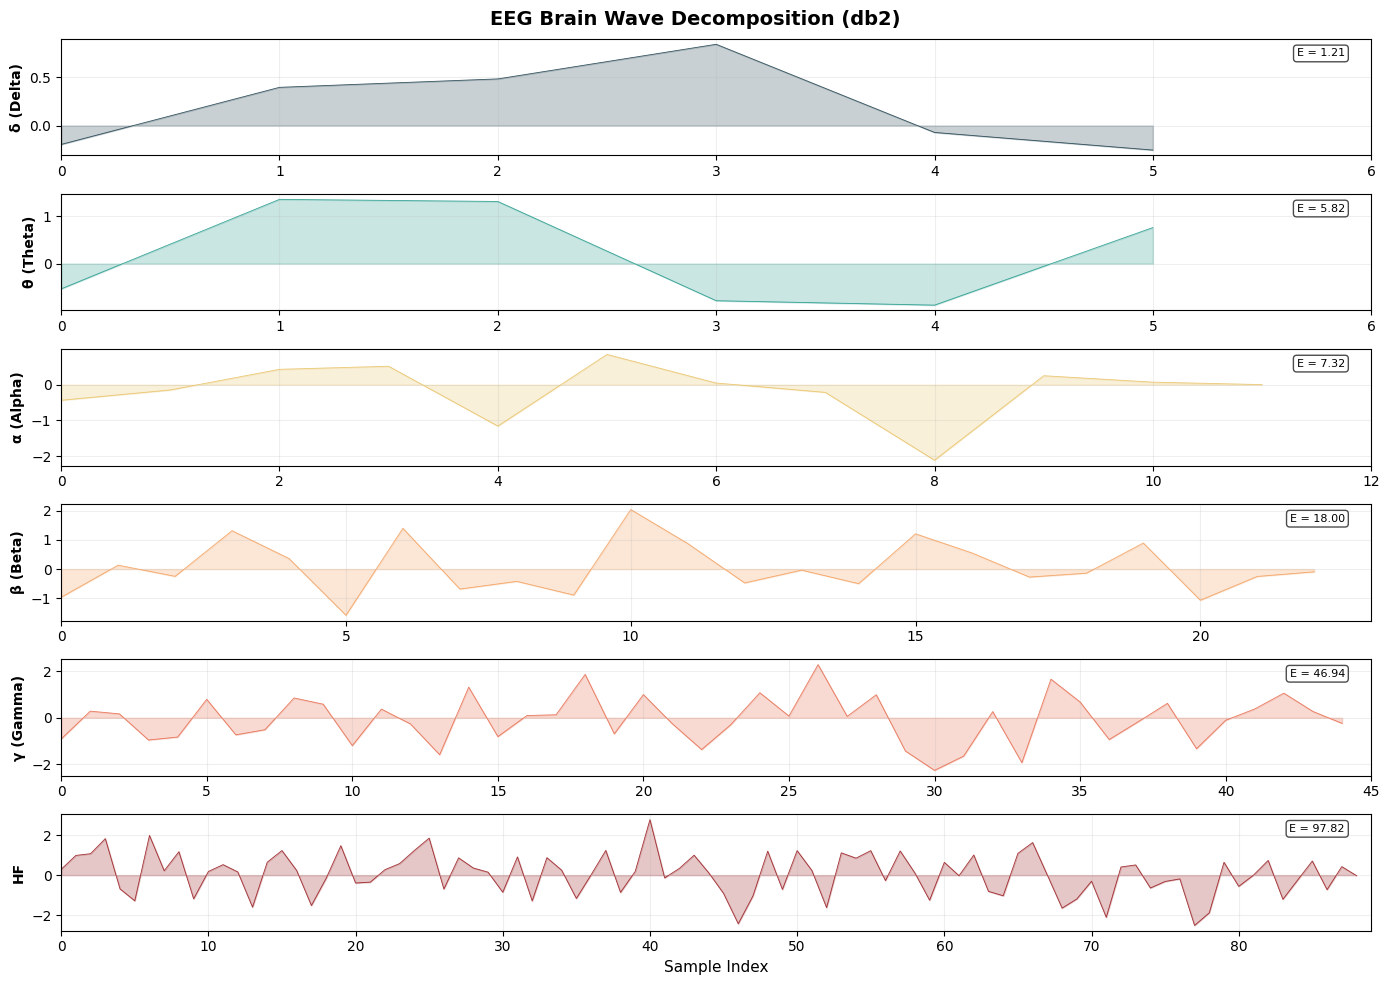

In [212]:
# Create a test EEG-like signal
signal = np.random.randn(178)  # Typical EEG segment length
wavelet = 'db2'
level = 5  # 5 levels for EEG bands (delta, theta, alpha, beta, gamma)

# Extract features
features = extract_dwt_features(signal, wavelet=wavelet, level=level, feature_set='full')
feature_names = get_feature_names(level, 'full')

print(f"Signal length: {len(signal)}")
print(f"Number of features extracted: {len(features)}")
print(f"\nFeature breakdown:")
print(f"  - {level + 1} sub-bands (1 approximation + {level} details)")
print(f"  - 3 features per sub-band (energy, entropy, std)")
print(f"  - Total: {(level + 1) * 3} features")

print(f"\nFeature names:")
for i, (name, value) in enumerate(zip(feature_names, features)):
    print(f"  {i+1:2d}. {name:20s} = {value:.4f}")

# Visualize DWT decomposition
coeffs = dwt(signal, wavelet=wavelet, level=level, verbose=False)
fig = plot_brain_wave_bands(
    coeffs,
    band_names=['δ (Delta)', 'θ (Theta)', 'α (Alpha)', 'β (Beta)', 'γ (Gamma)', 'HF'][:len(coeffs)],
    title="EEG Brain Wave Decomposition (db2)"
)
plt.show()


## Step 8: Loading EEG Data

Load the UCI Epileptic Seizure Recognition dataset and prepare it for processing.


Loading dataset from: Epileptic Seizure Recognition.csv
  Loaded 11500 samples with 178 features each
  Sampling rate: 173.61 Hz
  Signal duration: 1.025 seconds
  Binary labels: 2300 seizure, 9200 non-seizure
  Class ratio: 20.0% seizure

Dataset loaded successfully!
  Training set: 9200 samples
  Test set: 2300 samples
  Signal length: 178 samples
  Sampling rate: 173.61 Hz


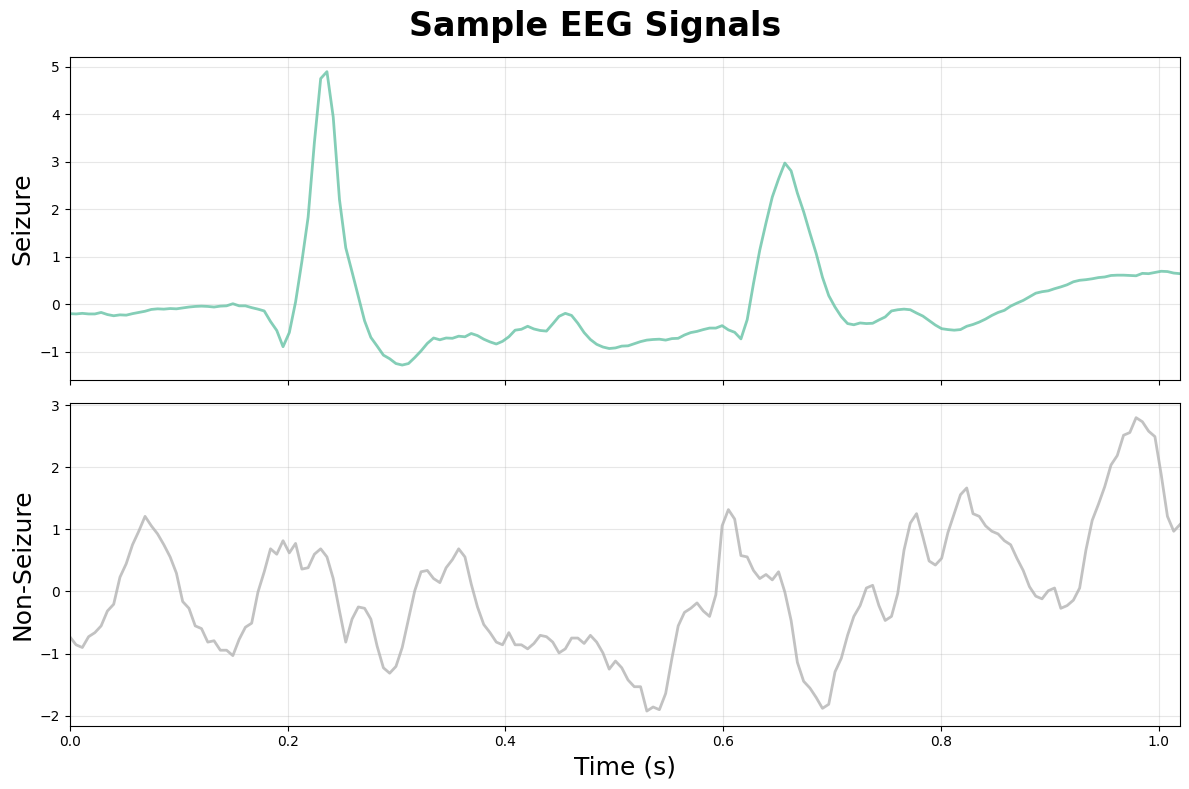

In [232]:

import importlib
import viz.signal_plots
importlib.reload(viz.signal_plots)
from viz.signal_plots import plot_signals  # ensure loaded fresh

# Load dataset
data_path = Path("Epileptic Seizure Recognition.csv")

if data_path.exists():
    X, y = load_epilepsy_data(data_path, binary=True, normalize=True, verbose=True)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=True, random_state=42
    )
    
    print(f"\nDataset loaded successfully!")
    print(f"  Training set: {len(X_train)} samples")
    print(f"  Test set: {len(X_test)} samples")
    print(f"  Signal length: {X_train.shape[1]} samples")
    print(f"  Sampling rate: {SAMPLING_RATE} Hz")
    
    # Visualize sample signals from each class
    seizure_idx = np.where(y_train == 1)[0][9]
    non_seizure_idx = np.where(y_train == 0)[0][9]
    
    fig = plot_signals(
        [X_train[seizure_idx], X_train[non_seizure_idx]],
        labels=["Seizure", "Non-Seizure"],
        sampling_rate=SAMPLING_RATE,
        title="Sample EEG Signals",
        stacked=True
    )
    plt.show()
else:
    print(f"Dataset not found at {data_path}")
    print("Please ensure 'Epileptic Seizure Recognition.csv' is in the project directory")


## Step 9: Complete Pipeline - Denoising

Apply DWT soft thresholding to denoise all signals in the dataset.


Denoising training signals...
  Processing signal 2000/9200
  Processing signal 4000/9200
  Processing signal 6000/9200
  Processing signal 8000/9200
Denoising test signals...
✓ Denoising complete!


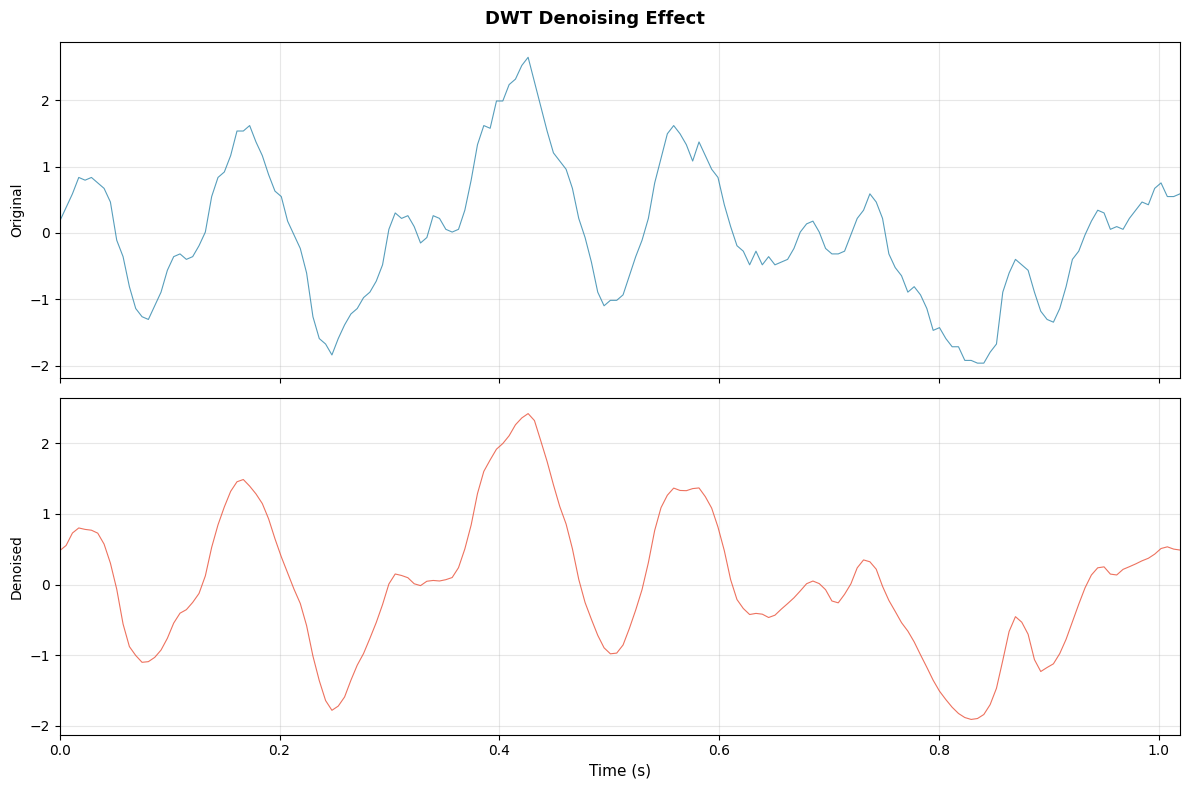

In [85]:
if 'X_train' in locals():
    # Denoise training signals
    print("Denoising training signals...")
    X_train_denoised = np.zeros_like(X_train)
    for i in range(len(X_train)):
        if (i + 1) % 2000 == 0:
            print(f"  Processing signal {i+1}/{len(X_train)}")
        X_train_denoised[i] = denoise_signal(X_train[i], wavelet='db4', level=3, verbose=False)
    
    # Denoise test signals
    print("Denoising test signals...")
    X_test_denoised = np.zeros_like(X_test)
    for i in range(len(X_test)):
        X_test_denoised[i] = denoise_signal(X_test[i], wavelet='db4', level=3, verbose=False)
    
    print("✓ Denoising complete!")
    
    # Visualize denoising effect on a sample
    sample_idx = 0
    fig = plot_signal_comparison(
        X_train[sample_idx], X_train_denoised[sample_idx],
        sampling_rate=SAMPLING_RATE,
        labels=["Original", "Denoised"],
        title="DWT Denoising Effect"
    )
    plt.show()
else:
    print("Please run the data loading cell first!")


## Step 10: Feature Extraction (Batch Processing)

Extract DWT features from all denoised signals. This creates the feature matrix for classification.


In [220]:
if 'X_train_denoised' in locals():
    # Extract features from training set
    print("Extracting features from training set...")
    features_train = extract_features_batch(
        X_train_denoised, wavelet='db2', level=5,
        feature_set='standard', verbose=True
    )
    
    # Extract features from test set
    print("\nExtracting features from test set...")
    features_test = extract_features_batch(
        X_test_denoised, wavelet='db2', level=5,
        feature_set='standard', verbose=True
    )
    
    feature_names = get_feature_names(5, 'standard')
    
    print(f"\n✓ Feature extraction complete!")
    print(f"  Training features shape: {features_train.shape}")
    print(f"  Test features shape: {features_test.shape}")
    print(f"  Number of features per sample: {features_train.shape[1]}")
    print(f"\n  Feature names: {feature_names[:5]}... (showing first 5)")
    
    # Show feature statistics
    print(f"\nFeature statistics (training set):")
    print(f"  Mean: {np.mean(features_train, axis=0)[:5]}")
    print(f"  Std:  {np.std(features_train, axis=0)[:5]}")
else:
    print("Please run the denoising cell first!")


Extracting features from training set...
  Processing signal 500/9200
  Processing signal 1000/9200
  Processing signal 1500/9200
  Processing signal 2000/9200
  Processing signal 2500/9200
  Processing signal 3000/9200
  Processing signal 3500/9200
  Processing signal 4000/9200
  Processing signal 4500/9200
  Processing signal 5000/9200
  Processing signal 5500/9200
  Processing signal 6000/9200
  Processing signal 6500/9200
  Processing signal 7000/9200
  Processing signal 7500/9200
  Processing signal 8000/9200
  Processing signal 8500/9200
  Processing signal 9000/9200

Extracting features from test set...
  Processing signal 500/2300
  Processing signal 1000/2300
  Processing signal 1500/2300
  Processing signal 2000/2300

✓ Feature extraction complete!
  Training features shape: (9200, 18)
  Test features shape: (2300, 18)
  Number of features per sample: 18

  Feature names: ['A5_energy', 'A5_entropy', 'A5_std', 'D5_energy', 'D5_entropy']... (showing first 5)

Feature statistics

## Step 11: Classification (Using Full Features)

Train a classifier using ALL extracted features (no dimensionality reduction). This gives the best performance.


Training classifier with FULL features (no dimensionality reduction)...
  Using all 18 features
  Classifier: SVM


Training SVM classifier...

Training Results:
  Accuracy: 0.9628
  F1 Score: 0.9033

Test Results:
  Accuracy: 0.9483
  Precision: 0.9089
  Recall: 0.8239
  F1 Score: 0.8643
  ROC-AUC: 0.9742

Confusion Matrix:
[[1802   38]
 [  81  379]]


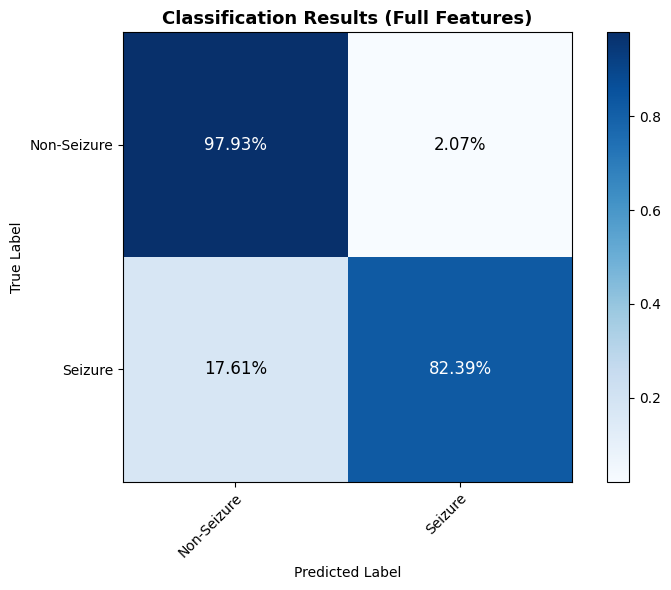


Classification Summary
Test Accuracy:  0.9483
Test Precision: 0.9089
Test Recall:    0.8239
Test F1 Score:  0.8643
Test ROC-AUC:   0.9742


In [221]:
if 'features_train' in locals():
    print("Training classifier with FULL features (no dimensionality reduction)...")
    print(f"  Using all {features_train.shape[1]} features")
    print(f"  Classifier: SVM\n")
    
    # Train and evaluate
    classifier, results = train_and_evaluate(
        features_train, y_train, features_test, y_test,
        model_type='svm', verbose=True
    )
    
    # Visualize confusion matrix
    fig = plot_confusion_matrix(
        results['confusion_matrix'],
        class_names=['Non-Seizure', 'Seizure'],
        title="Classification Results (Full Features)",
        normalize=True
    )
    plt.show()
    
    print("\n" + "="*70)
    print("Classification Summary")
    print("="*70)
    print(f"Test Accuracy:  {results['test_metrics']['accuracy']:.4f}")
    print(f"Test Precision: {results['test_metrics']['precision']:.4f}")
    print(f"Test Recall:    {results['test_metrics']['recall']:.4f}")
    print(f"Test F1 Score:  {results['test_metrics']['f1']:.4f}")
    print(f"Test ROC-AUC:   {results['test_metrics']['roc_auc']:.4f}")
else:
    print("Please run the feature extraction cell first!")


## Step 12: Visualization (Dimensionality Reduction for Display Only)

Use PCA/UMAP/t-SNE to visualize the feature space in 2D. **Note:** This is for visualization only - classification uses full features!


Reducing dimensions for visualization (PCA)...
  Note: This is for display only - classification used full features!

Explained variance: 35.61%, 15.14%
Total explained: 50.75%



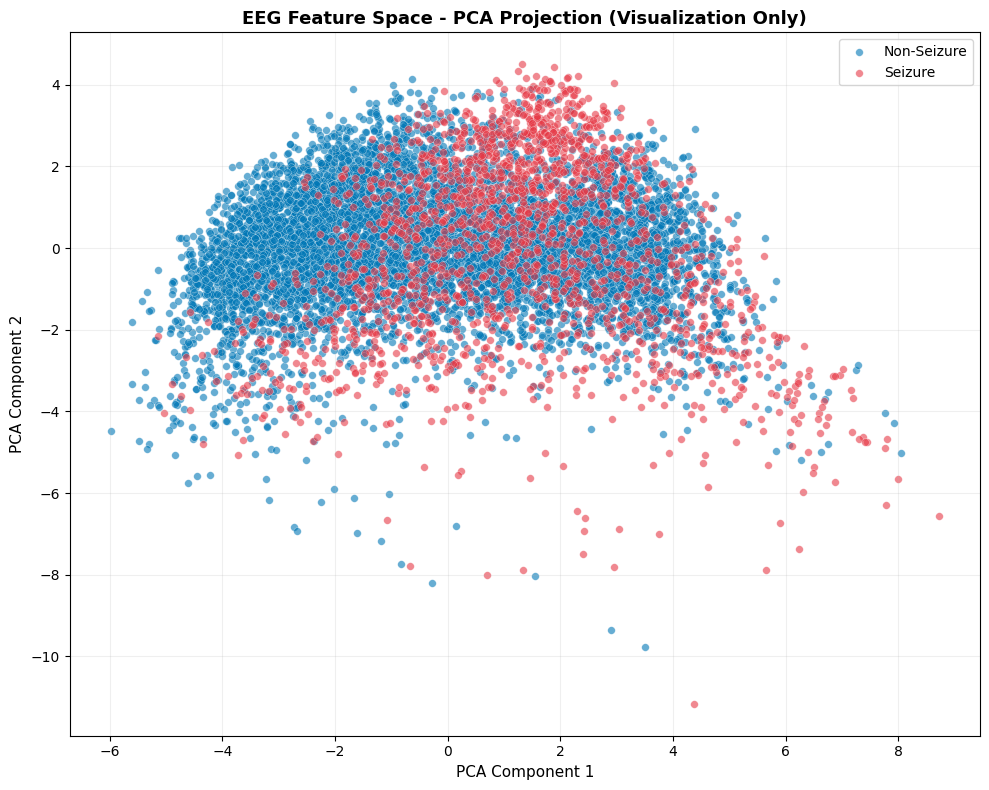


✓ Visualization complete!
  The classifier was trained on all features, not this 2D projection.


In [222]:
if 'features_train' in locals():
    # Reduce dimensions for visualization (NOT for classification!)
    print("Reducing dimensions for visualization (PCA)...")
    print("  Note: This is for display only - classification used full features!\n")
    
    reduced_train, reducer = reduce_dimensions(
        features_train, method='pca', n_components=2
    )
    
    # Get explained variance
    var_explained = reducer.get_explained_variance()
    if var_explained is not None:
        print(f"Explained variance: {var_explained[0]:.2%}, {var_explained[1]:.2%}")
        print(f"Total explained: {sum(var_explained):.2%}\n")
    
    # Visualize feature space
    fig = plot_feature_projection(
        reduced_train, y_train,
        method_name='PCA',
        class_names=['Non-Seizure', 'Seizure'],
        title="EEG Feature Space - PCA Projection (Visualization Only)"
    )
    plt.show()
    
    print("\n✓ Visualization complete!")
    print("  The classifier was trained on all features, not this 2D projection.")
else:
    print("Please run the feature extraction cell first!")
# Show PCA component contributions for interpretability




PCA Component Analysis - Most Important Features

Top 10 Most Important Features (by PCA contribution):
----------------------------------------------------------------------
 1. D1_energy           : 0.0665 (6.65%)
 2. D1_entropy          : 0.0659 (6.59%)
 3. D1_std              : 0.0652 (6.52%)
 4. D3_energy           : 0.0631 (6.31%)
 5. D3_std              : 0.0627 (6.27%)
 6. D2_energy           : 0.0594 (5.94%)
 7. D4_energy           : 0.0585 (5.85%)
 8. D2_std              : 0.0557 (5.57%)
 9. D2_entropy          : 0.0556 (5.56%)
10. D5_energy           : 0.0555 (5.55%)


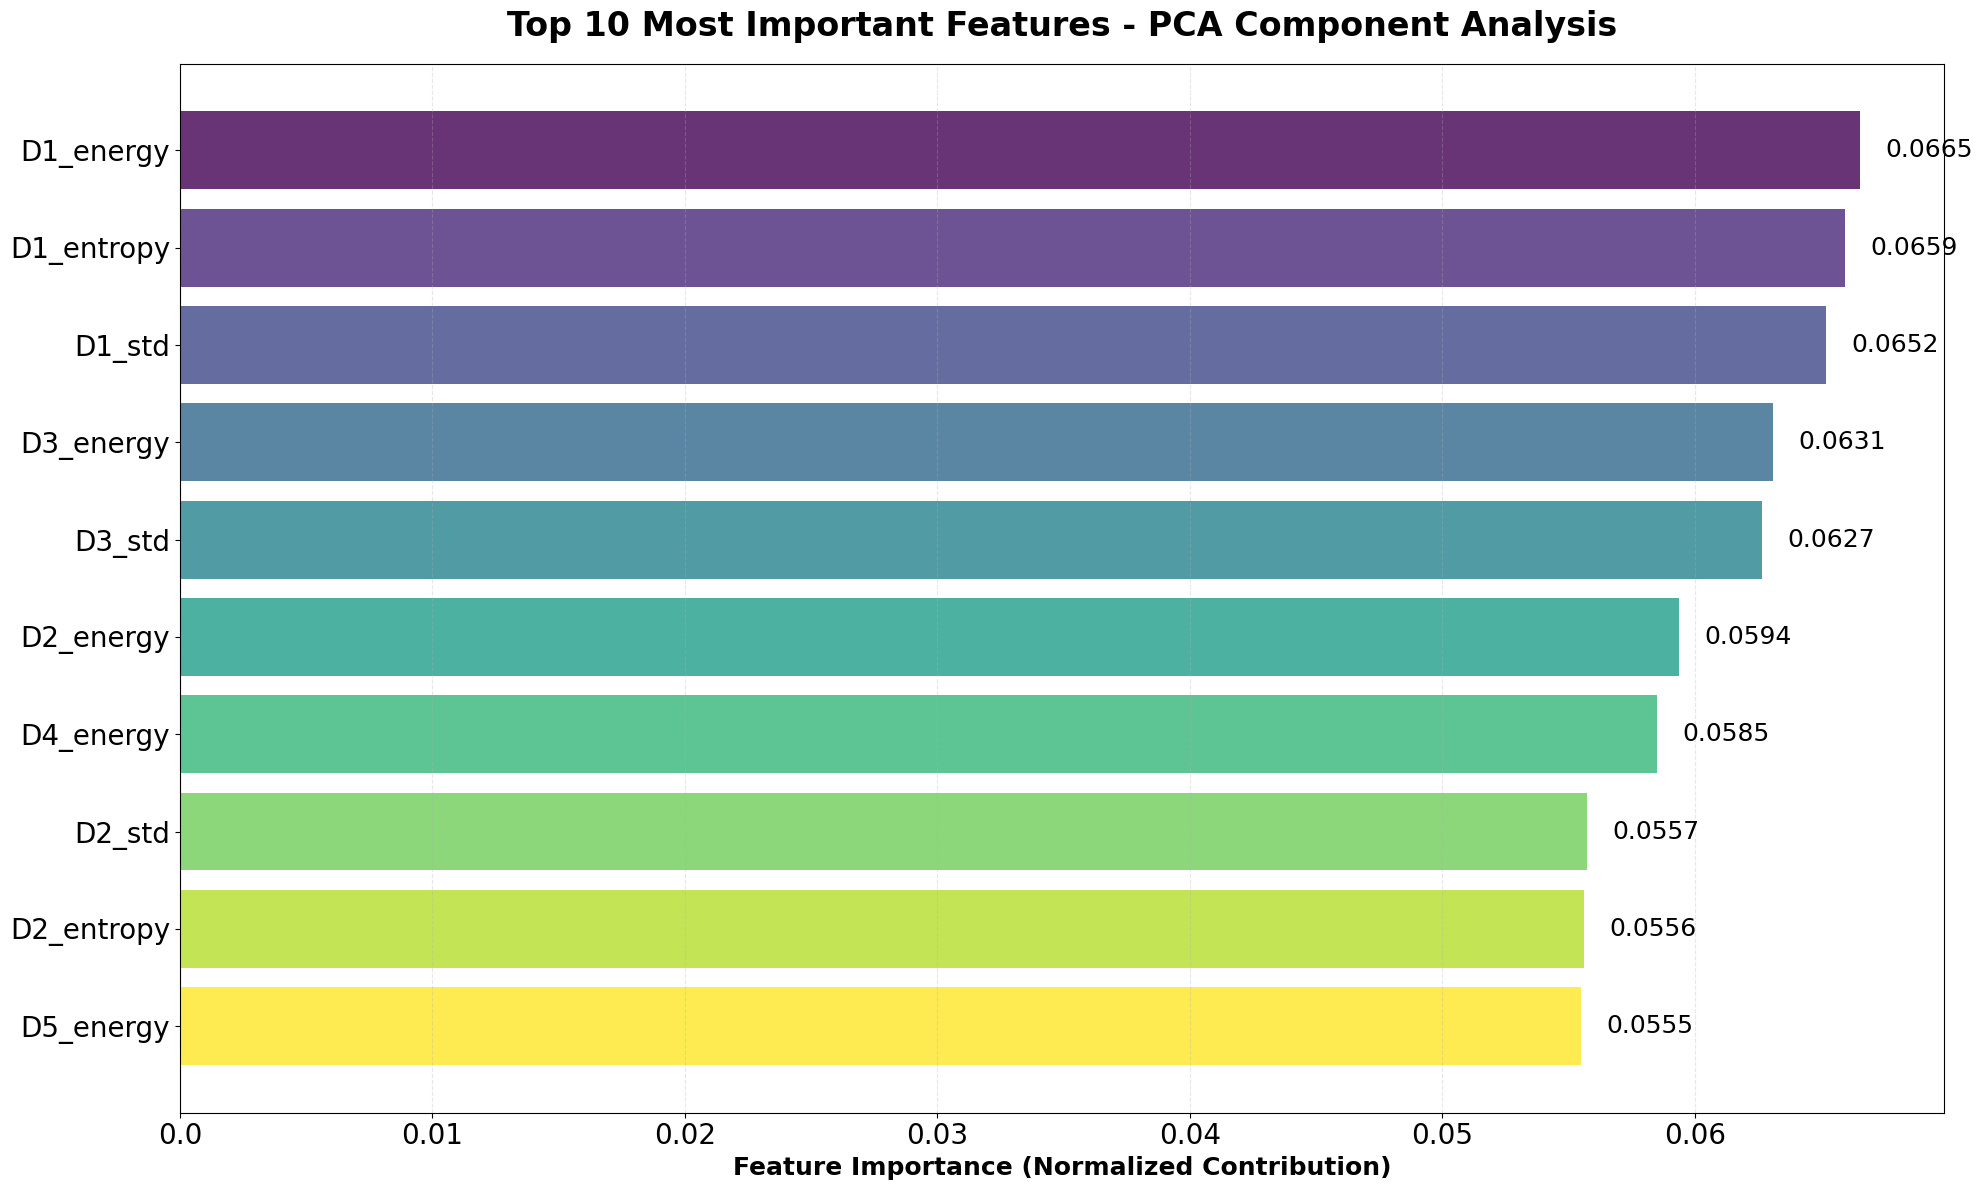


PCA Explained Variance:
  First 10 components: [0.35611536 0.15137501 0.11917973 0.08218202 0.05888716 0.05490158
 0.04985071 0.04163173 0.03195315 0.02398224]
  Cumulative variance: [0.35611536 0.50749037 0.6266701  0.70885211 0.76773927 0.82264085
 0.87249156 0.9141233  0.94607644 0.97005868]
  Components needed for 95% variance: 10


In [223]:
if 'features_train' in locals() and 'feature_names' in locals():
    print("\nPCA Component Analysis - Most Important Features")
    print("="*70)
    
    # Analyze PCA components
    pca_results = analyze_pca_components(features_train, feature_names=feature_names)
    
    # Get feature importance
    if 'feature_importance' in pca_results:
        feature_importance = pca_results['feature_importance']
        
        # Sort features by importance (descending)
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        
        # Get top N features (e.g., top 15)
        top_n = 10
        top_features = sorted_features[:top_n]
        
        # Extract names and values
        feature_names_sorted = [f[0] for f in top_features]
        importance_values = [f[1] for f in top_features]
        
        # Print summary
        print(f"\nTop {top_n} Most Important Features (by PCA contribution):")
        print("-" * 70)
        for i, (name, importance) in enumerate(top_features, 1):
            print(f"{i:2d}. {name:<20s}: {importance:.4f} ({importance*100:.2f}%)")
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(20, 12))
        
        # Create horizontal bar chart
        y_pos = np.arange(len(feature_names_sorted))
        colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names_sorted)))
        
        bars = ax.barh(y_pos, importance_values, color=colors, alpha=0.8)
        
        # Customize the plot
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_names_sorted, fontsize=20)
        ax.set_xticklabels(ax.get_xticks(), fontsize=20)
        ax.set_xlabel('Feature Importance (Normalized Contribution)', fontsize=18, fontweight='bold')
        ax.set_title(f'Top {top_n} Most Important Features - PCA Component Analysis', 
                    fontsize=24, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, importance_values)):
            width = bar.get_width()
            ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                   f'{val:.4f}', ha='left', va='center', fontsize=18)
        
        # Invert y-axis to show highest importance at top
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        # Print explained variance info
        print(f"\nPCA Explained Variance:")
        print(f"  First 10 components: {pca_results['explained_variance'][:10]}")
        print(f"  Cumulative variance: {pca_results['cumulative_variance'][:10]}")
        print(f"  Components needed for 95% variance: {pca_results['n_components_95pct']}")
        
    else:
        print("Warning: Feature names not provided, cannot compute feature importance.")
else:
    print("Please run the feature extraction cell first!")

In [224]:
feature_names

['A5_energy',
 'A5_entropy',
 'A5_std',
 'D5_energy',
 'D5_entropy',
 'D5_std',
 'D4_energy',
 'D4_entropy',
 'D4_std',
 'D3_energy',
 'D3_entropy',
 'D3_std',
 'D2_energy',
 'D2_entropy',
 'D2_std',
 'D1_energy',
 'D1_entropy',
 'D1_std']

In [97]:
cumvar=pca_results['cumulative_variance']
n_for_95 = np.argmax( cumvar>= 0.95) + 1
cumvar

array([0.34943124, 0.55489902, 0.66583651, 0.74023443, 0.80439766])

## Summary

This notebook demonstrated the complete EEG Epilepsy Classification pipeline:

1. **Basic Functions**: Wavelet filters, periodic convolution
2. **Single-Level DWT**: Decomposition into approximation and detail
3. **Multi-Level DWT**: Recursive decomposition with perfect reconstruction
4. **CWT**: Time-frequency representation with scalograms
5. **Denoising**: Soft thresholding for noise removal
6. **Feature Extraction**: Statistical features from DWT sub-bands
7. **Data Loading**: UCI Epileptic Seizure Recognition dataset
8. **Complete Pipeline**: Denoising → Feature Extraction → Classification
9. **Classification**: Using **ALL features** (no dimensionality reduction)
10. **Visualization**: PCA/UMAP/t-SNE for display only

### Key Points:
- ✅ DWT provides perfect reconstruction (error < 1e-15)
- ✅ Classification uses **full feature space** for best performance
- ✅ Dimensionality reduction is **only for visualization**
- ✅ Modular design allows easy experimentation

### Next Steps:
- Try different wavelets (db2, db6, sym4, etc.)
- Experiment with different feature sets ('full', 'minimal')
- Try different classifiers (XGBoost)
- Adjust denoising parameters
- Explore different projection methods (UMAP, t-SNE)


## Results Analysis: Cross-Validation Performance

This section visualizes the cross-validation results from the experiment runs, comparing different wavelets and classifiers.


In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load results
results_path = Path("results/results_summary copy.csv")
df = pd.read_csv(results_path)

# Extract wavelet family and length
def extract_wavelet_info(wavelet_name):
    """Extract family and length from wavelet name"""
    if wavelet_name.startswith('db'):
        family = 'Daubechies'
        length = int(wavelet_name[2:]) if wavelet_name[2:].isdigit() else 1
    elif wavelet_name.startswith('sym'):
        family = 'Symlets'
        length = int(wavelet_name[3:]) if wavelet_name[3:].isdigit() else 1
    elif wavelet_name.startswith('coif'):
        family = 'Coiflets'
        length = int(wavelet_name[4:]) if wavelet_name[4:].isdigit() else 1
    elif wavelet_name.startswith('bior'):
        family = 'Biorthogonal'
        parts = wavelet_name[4:].split('.')
        length = int(parts[0]) if parts[0].isdigit() else 1
    elif wavelet_name == 'haar':
        family = 'Haar'
        length = 1
    else:
        family = 'Other'
        length = 0
    return family, length

df[['family', 'length']] = df['wavelet'].apply(
    lambda x: pd.Series(extract_wavelet_info(x))
)

# Extract CV metrics (mean values only, ignore std for now)
classifiers = ['svm', 'xgboost', 'random_forest']
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print("Loaded results for", len(df), "wavelets")
print("\nWavelet families:", df['family'].unique())
print("\nWavelet lengths:", sorted(df['length'].unique()))
print("\nAvailable classifiers:", classifiers)
print("\nAvailable metrics:", metrics)


ModuleNotFoundError: No module named 'seaborn'

### 1. Classifier Comparison: F1 Score Across All Wavelets


In [ ]:
# Extract F1 scores for each classifier
f1_data = []
for clf in classifiers:
    col = f'{clf}_cv_f1_mean'
    for idx, row in df.iterrows():
        f1_data.append({
            'wavelet': row['wavelet'],
            'classifier': clf.upper(),
            'f1': row[col],
            'f1_std': row[f'{clf}_cv_f1_std'],
            'family': row['family'],
            'length': row['length']
        })

f1_df = pd.DataFrame(f1_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(16, 8))

# Group by wavelet
wavelets = f1_df['wavelet'].unique()
x = np.arange(len(wavelets))
width = 0.25

for i, clf in enumerate(['SVM', 'XGBOOST', 'RANDOM_FOREST']):
    clf_data = f1_df[f1_df['classifier'] == clf]
    values = [clf_data[clf_data['wavelet'] == w]['f1'].values[0] if len(clf_data[clf_data['wavelet'] == w]) > 0 else 0 
              for w in wavelets]
    stds = [clf_data[clf_data['wavelet'] == w]['f1_std'].values[0] if len(clf_data[clf_data['wavelet'] == w]) > 0 else 0 
            for w in wavelets]
    
    offset = (i - 1) * width
    bars = ax.bar(x + offset, values, width, label=clf, alpha=0.8, yerr=stds, capsize=3)

ax.set_xlabel('Wavelet', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score (Cross-Validation Mean)', fontsize=12, fontweight='bold')
ax.set_title('Classifier Comparison: F1 Score Across All Wavelets', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(wavelets, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.6, 1.0])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("F1 SCORE SUMMARY STATISTICS")
print("="*70)
for clf in ['SVM', 'XGBOOST', 'RANDOM_FOREST']:
    clf_data = f1_df[f1_df['classifier'] == clf]['f1']
    print(f"\n{clf}:")
    print(f"  Mean F1: {clf_data.mean():.4f}")
    print(f"  Std F1:  {clf_data.std():.4f}")
    print(f"  Min F1:  {clf_data.min():.4f}")
    print(f"  Max F1:  {clf_data.max():.4f}")
    best_wavelet = f1_df[(f1_df['classifier'] == clf) & (f1_df['f1'] == clf_data.max())]['wavelet'].values[0]
    print(f"  Best:    {best_wavelet} (F1={clf_data.max():.4f})")


### 2. Wavelet Family Comparison by Length (SVM Fixed)


In [ ]:
# Filter for SVM only
svm_df = df.copy()

# Group by family and length
family_length_data = []
for family in svm_df['family'].unique():
    family_data = svm_df[svm_df['family'] == family]
    for length in sorted(family_data['length'].unique()):
        length_data = family_data[family_data['length'] == length]
        if len(length_data) > 0:
            # Take the first (or average if multiple) wavelet of this length
            row = length_data.iloc[0]
            family_length_data.append({
                'family': family,
                'length': length,
                'f1': row['svm_cv_f1_mean'],
                'accuracy': row['svm_cv_accuracy_mean'],
                'precision': row['svm_cv_precision_mean'],
                'recall': row['svm_cv_recall_mean'],
                'roc_auc': row['svm_cv_roc_auc_mean'],
                'wavelet': row['wavelet']
            })

fl_df = pd.DataFrame(family_length_data)

# Create subplots for different metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
metric_labels = ['F1 Score', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx]
    
    families = fl_df['family'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(families)))
    
    for i, family in enumerate(families):
        family_data = fl_df[fl_df['family'] == family].sort_values('length')
        if len(family_data) > 0:
            ax.plot(family_data['length'], family_data[metric], 
                   marker='o', linewidth=2, markersize=8, label=family, color=colors[i])
    
    ax.set_xlabel('Wavelet Length', fontsize=11, fontweight='bold')
    ax.set_ylabel(label, fontsize=11, fontweight='bold')
    ax.set_title(f'SVM: {label} vs Wavelet Length', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.7, 1.0])

# Remove the last empty subplot
axes[5].axis('off')

plt.suptitle('SVM Performance: Wavelet Family Comparison by Length', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("SVM: Best Performance by Family and Length")
print("="*70)
for family in sorted(fl_df['family'].unique()):
    family_data = fl_df[fl_df['family'] == family]
    best = family_data.loc[family_data['f1'].idxmax()]
    print(f"\n{family} (length {best['length']}):")
    print(f"  Wavelet: {best['wavelet']}")
    print(f"  F1:      {best['f1']:.4f}")
    print(f"  Accuracy: {best['accuracy']:.4f}")
    print(f"  ROC-AUC:  {best['roc_auc']:.4f}")


### 3. All Metrics for Length 4 Wavelets (Cross-Validation)


In [ ]:
# Filter for length 4 wavelets
length4_df = df[df['length'] == 4].copy()

if len(length4_df) > 0:
    # Prepare data for grouped bar chart
    wavelets_l4 = length4_df['wavelet'].values
    metrics_data = []
    
    for clf in classifiers:
        for metric in metrics:
            col_mean = f'{clf}_cv_{metric}_mean'
            col_std = f'{clf}_cv_{metric}_std'
            for idx, row in length4_df.iterrows():
                metrics_data.append({
                    'wavelet': row['wavelet'],
                    'classifier': clf.upper(),
                    'metric': metric.upper(),
                    'value': row[col_mean],
                    'std': row[col_std]
                })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    n_wavelets = len(wavelets_l4)
    n_metrics = len(metrics)
    n_classifiers = len(classifiers)
    
    x = np.arange(n_wavelets)
    total_width = 0.8
    width = total_width / (n_metrics * n_classifiers)
    
    # Color scheme
    metric_colors = {'ACCURACY': '#1f77b4', 'PRECISION': '#ff7f0e', 
                     'RECALL': '#2ca02c', 'F1': '#d62728', 'ROC_AUC': '#9467bd'}
    classifier_styles = {'SVM': '-', 'XGBOOST': '--', 'RANDOM_FOREST': ':'}
    
    offset = -total_width/2 + width/2
    bars_list = []
    labels_list = []
    
    for metric in metrics:
        metric_upper = metric.upper()
        for clf in ['SVM', 'XGBOOST', 'RANDOM_FOREST']:
            data = metrics_df[(metrics_df['metric'] == metric_upper) & 
                             (metrics_df['classifier'] == clf)]
            values = [data[data['wavelet'] == w]['value'].values[0] 
                     if len(data[data['wavelet'] == w]) > 0 else 0 
                     for w in wavelets_l4]
            stds = [data[data['wavelet'] == w]['std'].values[0] 
                   if len(data[data['wavelet'] == w]) > 0 else 0 
                   for w in wavelets_l4]
            
            bars = ax.bar(x + offset, values, width, 
                        label=f'{clf} {metric_upper}', 
                        color=metric_colors[metric_upper],
                        alpha=0.7 if clf == 'SVM' else (0.5 if clf == 'XGBOOST' else 0.3),
                        yerr=stds, capsize=2)
            bars_list.append(bars)
            labels_list.append(f'{clf} {metric_upper}')
            offset += width
    
    ax.set_xlabel('Wavelet (Length 4)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Metric Value (CV Mean)', fontsize=12, fontweight='bold')
    ax.set_title('All Metrics for Length 4 Wavelets (Cross-Validation)', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(wavelets_l4, rotation=45, ha='right')
    ax.legend(loc='upper left', ncol=3, fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.5, 1.0])
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "="*70)
    print("Length 4 Wavelets: Cross-Validation Performance Summary")
    print("="*70)
    for wavelet in wavelets_l4:
        print(f"\n{wavelet.upper()}:")
        for clf in classifiers:
            print(f"  {clf.upper()}:")
            for metric in metrics:
                col_mean = f'{clf}_cv_{metric}_mean'
                col_std = f'{clf}_cv_{metric}_std'
                val = length4_df[length4_df['wavelet'] == wavelet][col_mean].values[0]
                std = length4_df[length4_df['wavelet'] == wavelet][col_std].values[0]
                print(f"    {metric.upper()}: {val:.4f} ± {std:.4f}")
else:
    print("No length 4 wavelets found in the results!")


### 4. Heatmap: All Wavelets vs All Metrics (F1 Score)


In [ ]:
# Create heatmap for F1 scores
heatmap_data = []
for clf in classifiers:
    col = f'{clf}_cv_f1_mean'
    heatmap_data.append(df[col].values)

heatmap_array = np.array(heatmap_data)
heatmap_df = pd.DataFrame(heatmap_array, 
                         index=[c.upper() for c in classifiers],
                         columns=df['wavelet'].values)

# Create heatmap
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', 
           vmin=0.7, vmax=1.0, cbar_kws={'label': 'F1 Score (CV Mean)'},
           linewidths=0.5, linecolor='gray', ax=ax)

ax.set_xlabel('Wavelet', fontsize=12, fontweight='bold')
ax.set_ylabel('Classifier', fontsize=12, fontweight='bold')
ax.set_title('F1 Score Heatmap: Classifiers vs Wavelets (Cross-Validation)', 
            fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 5. Performance Stability: Coefficient of Variation (CV Std / CV Mean)


In [ ]:
# Calculate coefficient of variation (CV) for F1 scores
# CV = std / mean (lower is better, more stable)
stability_data = []
for clf in classifiers:
    for idx, row in df.iterrows():
        mean_f1 = row[f'{clf}_cv_f1_mean']
        std_f1 = row[f'{clf}_cv_f1_std']
        cv = std_f1 / mean_f1 if mean_f1 > 0 else 0
        stability_data.append({
            'wavelet': row['wavelet'],
            'classifier': clf.upper(),
            'cv': cv,
            'mean_f1': mean_f1,
            'std_f1': std_f1,
            'family': row['family'],
            'length': row['length']
        })

stability_df = pd.DataFrame(stability_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(16, 8))

wavelets = stability_df['wavelet'].unique()
x = np.arange(len(wavelets))
width = 0.25

for i, clf in enumerate(['SVM', 'XGBOOST', 'RANDOM_FOREST']):
    clf_data = stability_df[stability_df['classifier'] == clf]
    values = [clf_data[clf_data['wavelet'] == w]['cv'].values[0] 
              if len(clf_data[clf_data['wavelet'] == w]) > 0 else 0 
              for w in wavelets]
    
    offset = (i - 1) * width
    bars = ax.bar(x + offset, values, width, label=clf, alpha=0.8)

ax.set_xlabel('Wavelet', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient of Variation (Std/Mean)', fontsize=12, fontweight='bold')
ax.set_title('Performance Stability: Lower CV = More Stable Performance', 
            fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(wavelets, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print most stable configurations
print("\n" + "="*70)
print("Most Stable Configurations (Lowest CV)")
print("="*70)
for clf in ['SVM', 'XGBOOST', 'RANDOM_FOREST']:
    clf_data = stability_df[stability_df['classifier'] == clf]
    most_stable = clf_data.loc[clf_data['cv'].idxmin()]
    print(f"\n{clf}:")
    print(f"  Wavelet: {most_stable['wavelet']}")
    print(f"  CV:      {most_stable['cv']:.6f}")
    print(f"  F1:      {most_stable['mean_f1']:.4f} ± {most_stable['std_f1']:.4f}")


### 6. Best Overall Configuration Analysis


In [ ]:
# Find best configuration for each metric
print("="*70)
print("BEST CONFIGURATIONS BY METRIC (Cross-Validation)")
print("="*70)

for metric in metrics:
    print(f"\n{metric.upper()}:")
    best_value = 0
    best_config = None
    
    for clf in classifiers:
        col = f'{clf}_cv_{metric}_mean'
        max_idx = df[col].idxmax()
        max_val = df.loc[max_idx, col]
        
        if max_val > best_value:
            best_value = max_val
            best_config = {
                'classifier': clf.upper(),
                'wavelet': df.loc[max_idx, 'wavelet'],
                'value': max_val,
                'std': df.loc[max_idx, f'{clf}_cv_{metric}_std'],
                'family': df.loc[max_idx, 'family'],
                'length': df.loc[max_idx, 'length']
            }
    
    if best_config:
        print(f"  Best: {best_config['classifier']} + {best_config['wavelet']}")
        print(f"  Value: {best_config['value']:.4f} ± {best_config['std']:.4f}")
        print(f"  Family: {best_config['family']}, Length: {best_config['length']}")

# Overall best (by F1)
print("\n" + "="*70)
print("OVERALL BEST CONFIGURATION (by F1 Score)")
print("="*70)
best_f1 = 0
best_overall = None

for clf in classifiers:
    col = f'{clf}_cv_f1_mean'
    max_idx = df[col].idxmax()
    max_val = df.loc[max_idx, col]
    
    if max_val > best_f1:
        best_f1 = max_val
        best_overall = {
            'classifier': clf.upper(),
            'wavelet': df.loc[max_idx, 'wavelet'],
            'f1': max_val,
            'f1_std': df.loc[max_idx, f'{clf}_cv_f1_std'],
            'accuracy': df.loc[max_idx, f'{clf}_cv_accuracy_mean'],
            'precision': df.loc[max_idx, f'{clf}_cv_precision_mean'],
            'recall': df.loc[max_idx, f'{clf}_cv_recall_mean'],
            'roc_auc': df.loc[max_idx, f'{clf}_cv_roc_auc_mean'],
            'family': df.loc[max_idx, 'family'],
            'length': df.loc[max_idx, 'length']
        }

if best_overall:
    print(f"\n🏆 Best Configuration: {best_overall['classifier']} + {best_overall['wavelet']}")
    print(f"\nPerformance Metrics:")
    print(f"  F1 Score:    {best_overall['f1']:.4f} ± {best_overall['f1_std']:.4f}")
    print(f"  Accuracy:    {best_overall['accuracy']:.4f}")
    print(f"  Precision:   {best_overall['precision']:.4f}")
    print(f"  Recall:      {best_overall['recall']:.4f}")
    print(f"  ROC-AUC:     {best_overall['roc_auc']:.4f}")
    print(f"\nWavelet Info:")
    print(f"  Family:      {best_overall['family']}")
    print(f"  Length:      {best_overall['length']}")
